In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import numpy as np
import pandas as pd
import os
from skimage import io
import tensorflow as tf
import keras
from keras import backend as K 
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.layers import GlobalAveragePooling2D, Dense, Activation, BatchNormalization, Dropout, Input
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
import cv2
from keras.applications.vgg16 import  VGG16, preprocess_input
from skimage.util import view_as_windows 
from scipy.io import loadmat
from scipy.stats import pearsonr, spearmanr
image_dir = '/content/PEID/encimg/'

<h1>Loading test Set </h1>

In [12]:
!unzip /content/drive/MyDrive/Projet-5-em/Project-kadid10k/PEID.zip

Archive:  /content/drive/MyDrive/Projet-5-em/Project-kadid10k/PEID.zip
   creating: PEID/
  inflating: PEID/data.mat           
   creating: PEID/encimg/
  inflating: PEID/encimg/airport_01_1.j2k  
  inflating: PEID/encimg/airport_01_2.j2k  
  inflating: PEID/encimg/airport_01_3.j2k  
  inflating: PEID/encimg/airport_01_4.j2k  
  inflating: PEID/encimg/airport_01_5.j2k  
  inflating: PEID/encimg/airport_02_1.jpg  
  inflating: PEID/encimg/airport_02_2.jpg  
  inflating: PEID/encimg/airport_02_3.jpg  
  inflating: PEID/encimg/airport_02_4.jpg  
  inflating: PEID/encimg/airport_02_5.jpg  
  inflating: PEID/encimg/airport_02_6.jpg  
  inflating: PEID/encimg/airport_03_1.j2k  
  inflating: PEID/encimg/airport_03_2.j2k  
  inflating: PEID/encimg/airport_03_3.j2k  
  inflating: PEID/encimg/airport_03_4.j2k  
  inflating: PEID/encimg/airport_03_5.j2k  
  inflating: PEID/encimg/airport_03_6.j2k  
  inflating: PEID/encimg/airport_04_1.j2k  
  inflating: PEID/encimg/airport_04_2.j2k  
  inflatin

In [13]:
!cp /content/PEID/refimg/* /content/PEID/encimg/
len(os.listdir('/content/PEID/encimg/'))

1100

In [14]:
testiq = pd.read_csv('/content/drive/MyDrive/Projet-5-em/Project-kadid10k/PEID_IQ_test_file.csv')
testiq.head()

,encrypted_image,reference_image,ground_truth
0,airport_01_4.j2k,airport.bmp,0.23
1,airport_02_6.jpg,airport.bmp,0.46
2,airport_04_5.j2k,airport.bmp,0.44
3,airport_06_2.j2k,airport.bmp,0.24
4,airport_07_3.bmp,airport.bmp,0.29


In [15]:
testvs = pd.read_csv('/content/drive/MyDrive/Projet-5-em/Project-kadid10k/PEID_VS_test_file.csv')
testvs.head()

,encrypted_image,reference_image,ground_truth
0,airport_01_4.j2k,airport.bmp,0.309524
1,airport_02_6.jpg,airport.bmp,0.722222
2,airport_04_5.j2k,airport.bmp,0.674603
3,airport_06_2.j2k,airport.bmp,0.349206
4,airport_07_3.bmp,airport.bmp,0.523810


In [16]:
test = testiq
test.insert(3, 'visual_quality',testvs['ground_truth'].values)
test

,encrypted_image,reference_image,ground_truth,visual_quality
0,airport_01_4.j2k,airport.bmp,0.23,0.309524
1,airport_02_6.jpg,airport.bmp,0.46,0.722222
2,airport_04_5.j2k,airport.bmp,0.44,0.674603
3,airport_06_2.j2k,airport.bmp,0.24,0.349206
4,airport_07_3.bmp,airport.bmp,0.29,0.523810
...,...,...,...,...
215,water_08_1.bmp,water.bmp,0.20,0.000000
216,water_09_5.bmp,water.bmp,0.27,0.547619
217,water_10_1.bmp,water.bmp,0.20,0.079365
218,water_10_2.bmp,water.bmp,0.20,0.134921


# Loading our trained model

In [17]:
model = keras.models.load_model('/content/drive/MyDrive/Projet-5-em/Project-kadid10k/VGG16-I04-V06/VGG160406.h5')

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Model Testing

In [25]:
y= []

for pos in range(0, len(test), 1):
  temp = test.iloc[pos:pos + 1] 

  for encimg in temp.encrypted_image:
    encrypted_image = image.load_img(image_dir+encimg)
    encrypted_image = image.img_to_array(encrypted_image)

    patches = view_as_windows(encrypted_image,(256, 256, 3),(256, 256, 3)).reshape((-1,256,256,3))

    for i in range(4):
      resized = cv2.resize(patches[i], (224,224))
      encrypted_batch = np.expand_dims(resized, axis=0)
      encrypted_batch = encrypted_batch / 255.0

      y.append(model.predict(encrypted_batch))

In [26]:
visual_s,image_s = [],[]

for val in y:
  image_s.append(val[0][0])
  visual_s.append(val[0][1])

In [27]:
iq = []
som, j = 0, 1
for elt in image_s:
  som += elt
  if j >= 4:
    iq.append(som/4)
    j = 0
    som = 0
  j = j+1

iq = np.array(iq)
iq.shape

(220,)

In [28]:
vs = []
somme, j = 0, 1
for elt in visual_s:
  somme += elt
  if j >= 4:
    vs.append(somme/4)
    j = 0
    somme = 0
  j = j+1

vs = np.array(vs)
vs.shape

(220,)

#Performance visualization

In [29]:
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

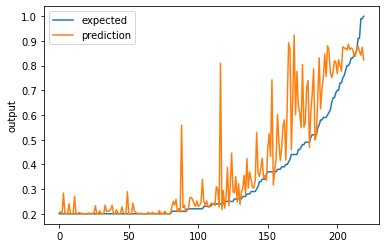

SpearmanrResult(correlation=0.9318984508415106, pvalue=5.609791802486296e-98)
PearsonrResult (0.9102002629776412, 2.076114262977006e-85)


In [30]:
chart_regression(iq, test.ground_truth.values)
print(spearmanr(test.ground_truth.values, iq))
print('PearsonrResult',pearsonr(test.ground_truth.values, iq))

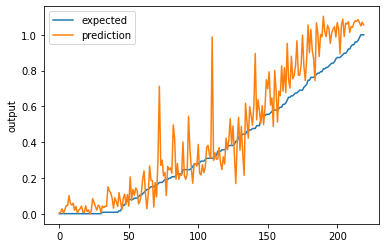

SpearmanrResult(correlation=0.9596882091087221, pvalue=3.8939764054060127e-122)
PearsonrResult (0.9603042715831864, 7.515710502660115e-123)


In [31]:
chart_regression(vs, test.visual_quality.values)
print(spearmanr(test.visual_quality.values, vs))
print('PearsonrResult',pearsonr(test.visual_quality.values, vs))